In [15]:
import torch
import numpy as np
import torchvision
import torchvision.transforms as transforms

import argparse
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets
#import vgg

import os
import matplotlib.pyplot as plt

## Data

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [11]:
trainset = torchvision.datasets.CIFAR10(root='./data/Cifar', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=5)

testset = torchvision.datasets.CIFAR10(root='./data/Cifar', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=5)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#cifar_train = torchvision.datasets.CIFAR10('data/Cifar', train=True, transform=None, target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


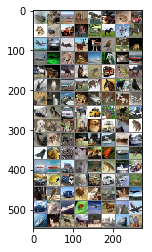

 ship  frog plane   cat plane   dog  frog   car   cat  frog truck   cat horse horse plane   dog plane   car plane horse  deer  bird  bird  deer plane plane  frog  bird  ship horse   cat  ship horse   cat horse horse  deer truck  frog  deer plane  frog plane horse   cat horse   dog  bird  deer  bird plane  frog   car  frog horse plane truck   dog   car horse   car  frog   dog truck


In [12]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(64)))


## Model

In [64]:
'''
Modified from https://github.com/pytorch/vision.git
'''
import math

import torch.nn as nn
import torch.nn.init as init

__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
         # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()


    def forward(self, x):
        x = self.features(x)
        #print(x.size)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfg = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 
          512, 512, 512, 512, 'M'],
}


def vgg11():
    """VGG 11-layer model (configuration "A")"""
    return VGG(make_layers(cfg['A']))


def vgg11_bn():
    """VGG 11-layer model (configuration "A") with batch normalization"""
    return VGG(make_layers(cfg['A'], batch_norm=True))


def vgg13():
    """VGG 13-layer model (configuration "B")"""
    return VGG(make_layers(cfg['B']))


def vgg13_bn():
    """VGG 13-layer model (configuration "B") with batch normalization"""
    return VGG(make_layers(cfg['B'], batch_norm=True))


def vgg16():
    """VGG 16-layer model (configuration "D")"""
    return VGG(make_layers(cfg['D']))


def vgg16_bn():
    """VGG 16-layer model (configuration "D") with batch normalization"""
    return VGG(make_layers(cfg['D'], batch_norm=True))


def vgg19():
    """VGG 19-layer model (configuration "E")"""
    return VGG(make_layers(cfg['E']))


def vgg19_bn():
    """VGG 19-layer model (configuration 'E') with batch normalization"""
    return VGG(make_layers(cfg['E'], batch_norm=True))

In [71]:
# model_names = sorted(name for name in vgg.__dict__
#     if name.islower() and not name.startswith("__")
#                      and name.startswith("vgg")
#                      and callable(vgg.__dict__[name]))


parser = argparse.ArgumentParser(description='PyTorch ImageNet Training')
#parser.add_argument('--arch', '-a', metavar='ARCH', default='vgg19',
#                    choices=model_names,
#                    help='model architecture: ' + ' | '.join(model_names) +
#                    ' (default: vgg19)')
parser.add_argument('-j', '--workers', default=10, type=int, metavar='N',
                    help='number of data loading workers (default: 4)')
parser.add_argument('--epochs', default=300, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('-b', '--batch-size', default=128, type=int,
                    metavar='N', help='mini-batch size (default: 128)')
parser.add_argument('--lr', '--learning-rate', default=0.05, type=float,
                    metavar='LR', help='initial learning rate')
parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                    help='momentum')
parser.add_argument('--weight-decay', '--wd', default=5e-4, type=float,
                    metavar='W', help='weight decay (default: 5e-4)')
parser.add_argument('--print-freq', '-p', default=100, type=int,
                    metavar='N', help='print frequency (default: 20)')
parser.add_argument('--resume', default='', type=str, metavar='PATH',
                    help='path to latest checkpoint (default: none)')
parser.add_argument('-e', '--evaluate', dest='evaluate', action='store_true',
                    help='evaluate model on validation set')
parser.add_argument('--pretrained', dest='pretrained', action='store_true',
                    help='use pre-trained model')
parser.add_argument('--half', dest='half', action='store_true',
                    help='use half-precision(16-bit) ')
parser.add_argument('--cpu', dest='cpu', action='store_true',
                    help='use cpu')
parser.add_argument('--save-dir', dest='save_dir',
                    help='The directory used to save the trained models',
                    default='save_temp', type=str)


best_prec1 = 0

In [72]:
def main():
    global args, best_prec1
    args = parser.parse_args("")


    # Check the save_dir exists or not
    if not os.path.exists(args.save_dir):
        os.makedirs(args.save_dir)

    #model = vgg.__dict__[args.arch]()
    #model = torchvision.models.vgg16()
    model = vgg19_bn()

    model.features = torch.nn.DataParallel(model.features)
    if args.cpu:
        print("Here")
        model.cpu()
    else:
        model.cuda()

    # optionally resume from a checkpoint
    if args.resume:
        if os.path.isfile(args.resume):
            print("=> loading checkpoint '{}'".format(args.resume))
            checkpoint = torch.load(args.resume)
            args.start_epoch = checkpoint['epoch']
            best_prec1 = checkpoint['best_prec1']
            model.load_state_dict(checkpoint['state_dict'])
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(args.evaluate, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(args.resume))

    cudnn.benchmark = True

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data/Cifar', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)

    val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data/Cifar', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=args.batch_size, shuffle=False,
        num_workers=args.workers, pin_memory=True)

    # define loss function (criterion) and pptimizer
    criterion = nn.CrossEntropyLoss()
    if args.cpu:
        criterion = criterion.cpu()
    else:
        criterion = criterion.cuda()

    if args.half:
        model.half()
        criterion.half()

    optimizer = torch.optim.SGD(model.parameters(), args.lr,
                                momentum=args.momentum,
                                weight_decay=args.weight_decay)

    if args.evaluate:
        validate(val_loader, model, criterion)
        return

    for epoch in range(args.start_epoch, args.epochs):
        adjust_learning_rate(optimizer, epoch)

        # train for one epoch
        train(train_loader, model, criterion, optimizer, epoch)

        # evaluate on validation set
        prec1 = validate(val_loader, model, criterion)

        # remember best prec@1 and save checkpoint
        is_best = prec1 > best_prec1
        best_prec1 = max(prec1, best_prec1)
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'best_prec1': best_prec1,
        }, is_best, filename=os.path.join(args.save_dir, 'checkpoint_{}.tar'.format(epoch)))

In [73]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)

        if args.cpu == False:
            input = input.cuda(async=True)
            target = target.cuda(async=True)
        if args.half:
            input = input.half()

        # compute output
        output = model(input)
        loss = criterion(output, target)

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))

In [74]:
def validate(val_loader, model, criterion):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        if args.cpu == False:
            input = input.cuda(async=True)
            target = target.cuda(async=True)

        if args.half:
            input = input.half()

        # compute output
        with torch.no_grad():
            output = model(input)
            loss = criterion(output, target)

        output = output.float()
        loss = loss.float()

        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % args.print_freq == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      i, len(val_loader), batch_time=batch_time, loss=losses,
                      top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))

    return top1.avg

In [75]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 2 every 30 epochs"""
    lr = args.lr * (0.5 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [76]:
if __name__ == '__main__':
    main()

Files already downloaded and verified
Epoch: [0][0/391]	Time 3.071 (3.071)	Data 2.924 (2.924)	Loss 2.3054 (2.3054)	Prec@1 10.938 (10.938)
Epoch: [0][100/391]	Time 0.064 (0.091)	Data 0.000 (0.029)	Loss 1.8668 (2.0903)	Prec@1 23.438 (17.690)
Epoch: [0][200/391]	Time 0.131 (0.076)	Data 0.000 (0.015)	Loss 1.8213 (1.9807)	Prec@1 32.031 (22.135)
Epoch: [0][300/391]	Time 0.065 (0.071)	Data 0.000 (0.010)	Loss 1.8286 (1.9046)	Prec@1 28.906 (25.218)
Test: [0/79]	Time 2.849 (2.849)	Loss 1.7133 (1.7133)	Prec@1 37.500 (37.500)
 * Prec@1 36.870
Epoch: [1][0/391]	Time 2.876 (2.876)	Data 2.781 (2.781)	Loss 1.6140 (1.6140)	Prec@1 40.625 (40.625)
Epoch: [1][100/391]	Time 0.067 (0.089)	Data 0.000 (0.028)	Loss 1.4544 (1.5760)	Prec@1 41.406 (39.859)
Epoch: [1][200/391]	Time 0.062 (0.076)	Data 0.000 (0.014)	Loss 1.5506 (1.5538)	Prec@1 38.281 (40.967)
Epoch: [1][300/391]	Time 0.059 (0.071)	Data 0.000 (0.010)	Loss 1.5387 (1.5162)	Prec@1 49.219 (43.148)
Test: [0/79]	Time 2.860 (2.860)	Loss 1.4442 (1.4442)	Prec

Epoch: [16][200/391]	Time 0.065 (0.076)	Data 0.000 (0.015)	Loss 0.3982 (0.5387)	Prec@1 89.844 (83.120)
Epoch: [16][300/391]	Time 0.065 (0.071)	Data 0.000 (0.010)	Loss 0.5087 (0.5352)	Prec@1 82.031 (83.153)
Test: [0/79]	Time 2.847 (2.847)	Loss 0.6278 (0.6278)	Prec@1 78.906 (78.906)
 * Prec@1 79.810
Epoch: [17][0/391]	Time 2.931 (2.931)	Data 2.837 (2.837)	Loss 0.4693 (0.4693)	Prec@1 83.594 (83.594)
Epoch: [17][100/391]	Time 0.068 (0.090)	Data 0.000 (0.028)	Loss 0.7048 (0.5185)	Prec@1 78.906 (84.050)
Epoch: [17][200/391]	Time 0.068 (0.075)	Data 0.001 (0.014)	Loss 0.5429 (0.5203)	Prec@1 83.594 (83.897)
Epoch: [17][300/391]	Time 0.050 (0.070)	Data 0.000 (0.010)	Loss 0.4526 (0.5209)	Prec@1 83.594 (83.887)
Test: [0/79]	Time 2.877 (2.877)	Loss 0.4584 (0.4584)	Prec@1 85.156 (85.156)
 * Prec@1 83.150
Epoch: [18][0/391]	Time 3.019 (3.019)	Data 2.915 (2.915)	Loss 0.5232 (0.5232)	Prec@1 82.031 (82.031)
Epoch: [18][100/391]	Time 0.062 (0.090)	Data 0.000 (0.029)	Loss 0.4987 (0.4891)	Prec@1 82.812 (84

Test: [0/79]	Time 2.813 (2.813)	Loss 0.2201 (0.2201)	Prec@1 92.188 (92.188)
 * Prec@1 88.320
Epoch: [33][0/391]	Time 2.953 (2.953)	Data 2.857 (2.857)	Loss 0.1244 (0.1244)	Prec@1 96.094 (96.094)
Epoch: [33][100/391]	Time 0.066 (0.090)	Data 0.001 (0.029)	Loss 0.2585 (0.2683)	Prec@1 92.969 (91.824)
Epoch: [33][200/391]	Time 0.060 (0.076)	Data 0.000 (0.015)	Loss 0.2873 (0.2683)	Prec@1 91.406 (91.772)
Epoch: [33][300/391]	Time 0.058 (0.071)	Data 0.000 (0.010)	Loss 0.1968 (0.2705)	Prec@1 91.406 (91.562)
Test: [0/79]	Time 3.011 (3.011)	Loss 0.2410 (0.2410)	Prec@1 91.406 (91.406)
 * Prec@1 88.760
Epoch: [34][0/391]	Time 2.935 (2.935)	Data 2.843 (2.843)	Loss 0.3165 (0.3165)	Prec@1 91.406 (91.406)
Epoch: [34][100/391]	Time 0.060 (0.090)	Data 0.000 (0.029)	Loss 0.2491 (0.2523)	Prec@1 92.188 (92.157)
Epoch: [34][200/391]	Time 0.052 (0.076)	Data 0.000 (0.014)	Loss 0.2659 (0.2625)	Prec@1 90.625 (91.849)
Epoch: [34][300/391]	Time 0.060 (0.071)	Data 0.000 (0.010)	Loss 0.2933 (0.2674)	Prec@1 89.844 (91

Epoch: [49][100/391]	Time 0.070 (0.091)	Data 0.000 (0.028)	Loss 0.3916 (0.2387)	Prec@1 89.062 (92.466)
Epoch: [49][200/391]	Time 0.074 (0.076)	Data 0.000 (0.014)	Loss 0.2079 (0.2504)	Prec@1 92.969 (92.125)
Epoch: [49][300/391]	Time 0.052 (0.071)	Data 0.000 (0.010)	Loss 0.2695 (0.2525)	Prec@1 90.625 (92.138)
Test: [0/79]	Time 2.859 (2.859)	Loss 0.3273 (0.3273)	Prec@1 91.406 (91.406)
 * Prec@1 86.660
Epoch: [50][0/391]	Time 2.924 (2.924)	Data 2.829 (2.829)	Loss 0.2309 (0.2309)	Prec@1 92.969 (92.969)
Epoch: [50][100/391]	Time 0.063 (0.091)	Data 0.000 (0.028)	Loss 0.2849 (0.2572)	Prec@1 92.188 (91.716)
Epoch: [50][200/391]	Time 0.065 (0.076)	Data 0.000 (0.014)	Loss 0.2269 (0.2586)	Prec@1 91.406 (91.915)
Epoch: [50][300/391]	Time 0.063 (0.072)	Data 0.000 (0.010)	Loss 0.3133 (0.2593)	Prec@1 88.281 (91.894)
Test: [0/79]	Time 2.890 (2.890)	Loss 0.2640 (0.2640)	Prec@1 92.188 (92.188)
 * Prec@1 87.810
Epoch: [51][0/391]	Time 2.906 (2.906)	Data 2.805 (2.805)	Loss 0.2379 (0.2379)	Prec@1 92.188 (92

Epoch: [65][300/391]	Time 0.063 (0.071)	Data 0.000 (0.010)	Loss 0.0690 (0.1155)	Prec@1 98.438 (96.294)
Test: [0/79]	Time 3.061 (3.061)	Loss 0.2729 (0.2729)	Prec@1 92.188 (92.188)
 * Prec@1 90.940
Epoch: [66][0/391]	Time 2.948 (2.948)	Data 2.840 (2.840)	Loss 0.0903 (0.0903)	Prec@1 97.656 (97.656)
Epoch: [66][100/391]	Time 0.062 (0.092)	Data 0.000 (0.028)	Loss 0.1170 (0.1100)	Prec@1 95.312 (96.504)
Epoch: [66][200/391]	Time 0.060 (0.078)	Data 0.000 (0.015)	Loss 0.1758 (0.1101)	Prec@1 93.750 (96.506)
Epoch: [66][300/391]	Time 0.057 (0.073)	Data 0.000 (0.010)	Loss 0.0965 (0.1119)	Prec@1 96.094 (96.392)
Test: [0/79]	Time 2.813 (2.813)	Loss 0.1558 (0.1558)	Prec@1 94.531 (94.531)
 * Prec@1 89.810
Epoch: [67][0/391]	Time 2.865 (2.865)	Data 2.765 (2.765)	Loss 0.1048 (0.1048)	Prec@1 95.312 (95.312)
Epoch: [67][100/391]	Time 0.061 (0.089)	Data 0.000 (0.028)	Loss 0.1271 (0.1096)	Prec@1 96.094 (96.589)
Epoch: [67][200/391]	Time 0.067 (0.076)	Data 0.000 (0.014)	Loss 0.0729 (0.1119)	Prec@1 96.875 (96

 * Prec@1 88.820
Epoch: [82][0/391]	Time 2.864 (2.864)	Data 2.785 (2.785)	Loss 0.1333 (0.1333)	Prec@1 97.656 (97.656)
Epoch: [82][100/391]	Time 0.066 (0.090)	Data 0.000 (0.028)	Loss 0.2357 (0.1267)	Prec@1 93.750 (96.055)
Epoch: [82][200/391]	Time 0.065 (0.075)	Data 0.000 (0.014)	Loss 0.0658 (0.1290)	Prec@1 97.656 (96.024)
Epoch: [82][300/391]	Time 0.049 (0.071)	Data 0.000 (0.010)	Loss 0.2447 (0.1325)	Prec@1 92.969 (95.969)
Test: [0/79]	Time 2.924 (2.924)	Loss 0.2704 (0.2704)	Prec@1 92.969 (92.969)
 * Prec@1 89.170
Epoch: [83][0/391]	Time 2.906 (2.906)	Data 2.816 (2.816)	Loss 0.0901 (0.0901)	Prec@1 97.656 (97.656)
Epoch: [83][100/391]	Time 0.061 (0.088)	Data 0.000 (0.028)	Loss 0.0888 (0.1267)	Prec@1 95.312 (96.210)
Epoch: [83][200/391]	Time 0.065 (0.074)	Data 0.000 (0.014)	Loss 0.1447 (0.1216)	Prec@1 95.312 (96.199)
Epoch: [83][300/391]	Time 0.048 (0.069)	Data 0.000 (0.010)	Loss 0.1639 (0.1258)	Prec@1 95.312 (96.112)
Test: [0/79]	Time 2.841 (2.841)	Loss 0.4296 (0.4296)	Prec@1 90.625 (90

Epoch: [98][200/391]	Time 0.061 (0.076)	Data 0.000 (0.014)	Loss 0.0465 (0.0416)	Prec@1 98.438 (98.725)
Epoch: [98][300/391]	Time 0.052 (0.071)	Data 0.000 (0.010)	Loss 0.0452 (0.0430)	Prec@1 99.219 (98.663)
Test: [0/79]	Time 2.832 (2.832)	Loss 0.1743 (0.1743)	Prec@1 95.312 (95.312)
 * Prec@1 91.830
Epoch: [99][0/391]	Time 2.897 (2.897)	Data 2.802 (2.802)	Loss 0.0389 (0.0389)	Prec@1 98.438 (98.438)
Epoch: [99][100/391]	Time 0.052 (0.090)	Data 0.000 (0.028)	Loss 0.0331 (0.0394)	Prec@1 98.438 (98.840)
Epoch: [99][200/391]	Time 0.053 (0.076)	Data 0.000 (0.014)	Loss 0.0239 (0.0422)	Prec@1 99.219 (98.717)
Epoch: [99][300/391]	Time 0.061 (0.071)	Data 0.000 (0.010)	Loss 0.0982 (0.0447)	Prec@1 98.438 (98.619)
Test: [0/79]	Time 2.869 (2.869)	Loss 0.2183 (0.2183)	Prec@1 92.969 (92.969)
 * Prec@1 91.360
Epoch: [100][0/391]	Time 2.952 (2.952)	Data 2.850 (2.850)	Loss 0.0177 (0.0177)	Prec@1 99.219 (99.219)
Epoch: [100][100/391]	Time 0.064 (0.091)	Data 0.000 (0.028)	Loss 0.0198 (0.0518)	Prec@1 100.000 

Epoch: [114][300/391]	Time 0.051 (0.071)	Data 0.000 (0.010)	Loss 0.0721 (0.0555)	Prec@1 96.875 (98.243)
Test: [0/79]	Time 2.853 (2.853)	Loss 0.2015 (0.2015)	Prec@1 95.312 (95.312)
 * Prec@1 91.510
Epoch: [115][0/391]	Time 2.912 (2.912)	Data 2.807 (2.807)	Loss 0.0473 (0.0473)	Prec@1 99.219 (99.219)
Epoch: [115][100/391]	Time 0.053 (0.088)	Data 0.000 (0.028)	Loss 0.1308 (0.0502)	Prec@1 96.875 (98.414)
Epoch: [115][200/391]	Time 0.147 (0.075)	Data 0.000 (0.014)	Loss 0.0444 (0.0484)	Prec@1 99.219 (98.461)
Epoch: [115][300/391]	Time 0.051 (0.070)	Data 0.000 (0.010)	Loss 0.1114 (0.0501)	Prec@1 97.656 (98.406)
Test: [0/79]	Time 2.906 (2.906)	Loss 0.2090 (0.2090)	Prec@1 96.094 (96.094)
 * Prec@1 90.870
Epoch: [116][0/391]	Time 2.935 (2.935)	Data 2.824 (2.824)	Loss 0.0408 (0.0408)	Prec@1 99.219 (99.219)
Epoch: [116][100/391]	Time 0.061 (0.090)	Data 0.000 (0.028)	Loss 0.0940 (0.0479)	Prec@1 97.656 (98.445)
Epoch: [116][200/391]	Time 0.065 (0.077)	Data 0.000 (0.014)	Loss 0.0448 (0.0500)	Prec@1 98

Test: [0/79]	Time 2.859 (2.859)	Loss 0.1578 (0.1578)	Prec@1 96.094 (96.094)
 * Prec@1 92.100
Epoch: [131][0/391]	Time 2.892 (2.892)	Data 2.796 (2.796)	Loss 0.0042 (0.0042)	Prec@1 100.000 (100.000)
Epoch: [131][100/391]	Time 0.062 (0.089)	Data 0.000 (0.028)	Loss 0.0223 (0.0129)	Prec@1 99.219 (99.652)
Epoch: [131][200/391]	Time 0.064 (0.075)	Data 0.000 (0.014)	Loss 0.0036 (0.0130)	Prec@1 100.000 (99.658)
Epoch: [131][300/391]	Time 0.072 (0.071)	Data 0.000 (0.010)	Loss 0.0101 (0.0145)	Prec@1 99.219 (99.616)
Test: [0/79]	Time 2.880 (2.880)	Loss 0.2805 (0.2805)	Prec@1 95.312 (95.312)
 * Prec@1 92.520
Epoch: [132][0/391]	Time 2.920 (2.920)	Data 2.808 (2.808)	Loss 0.0237 (0.0237)	Prec@1 99.219 (99.219)
Epoch: [132][100/391]	Time 0.060 (0.089)	Data 0.000 (0.028)	Loss 0.0017 (0.0138)	Prec@1 100.000 (99.606)
Epoch: [132][200/391]	Time 0.065 (0.076)	Data 0.000 (0.014)	Loss 0.0035 (0.0147)	Prec@1 100.000 (99.600)
Epoch: [132][300/391]	Time 0.066 (0.071)	Data 0.000 (0.010)	Loss 0.0043 (0.0143)	Prec

 * Prec@1 91.890
Epoch: [147][0/391]	Time 2.928 (2.928)	Data 2.816 (2.816)	Loss 0.0036 (0.0036)	Prec@1 100.000 (100.000)
Epoch: [147][100/391]	Time 0.062 (0.090)	Data 0.000 (0.028)	Loss 0.0022 (0.0134)	Prec@1 100.000 (99.629)
Epoch: [147][200/391]	Time 0.061 (0.075)	Data 0.000 (0.014)	Loss 0.0059 (0.0171)	Prec@1 100.000 (99.471)
Epoch: [147][300/391]	Time 0.063 (0.071)	Data 0.000 (0.010)	Loss 0.0164 (0.0167)	Prec@1 99.219 (99.458)
Test: [0/79]	Time 2.899 (2.899)	Loss 0.2820 (0.2820)	Prec@1 93.750 (93.750)
 * Prec@1 92.060
Epoch: [148][0/391]	Time 2.956 (2.956)	Data 2.850 (2.850)	Loss 0.0022 (0.0022)	Prec@1 100.000 (100.000)
Epoch: [148][100/391]	Time 0.055 (0.092)	Data 0.000 (0.029)	Loss 0.0031 (0.0209)	Prec@1 100.000 (99.389)
Epoch: [148][200/391]	Time 0.054 (0.077)	Data 0.000 (0.015)	Loss 0.0299 (0.0193)	Prec@1 99.219 (99.429)
Epoch: [148][300/391]	Time 0.066 (0.072)	Data 0.000 (0.010)	Loss 0.0049 (0.0192)	Prec@1 100.000 (99.447)
Test: [0/79]	Time 2.856 (2.856)	Loss 0.2320 (0.2320)	P

Epoch: [163][0/391]	Time 2.878 (2.878)	Data 2.769 (2.769)	Loss 0.0043 (0.0043)	Prec@1 100.000 (100.000)
Epoch: [163][100/391]	Time 0.061 (0.090)	Data 0.000 (0.028)	Loss 0.0012 (0.0045)	Prec@1 100.000 (99.861)
Epoch: [163][200/391]	Time 0.066 (0.075)	Data 0.000 (0.014)	Loss 0.0116 (0.0046)	Prec@1 99.219 (99.845)
Epoch: [163][300/391]	Time 0.057 (0.071)	Data 0.000 (0.010)	Loss 0.0038 (0.0048)	Prec@1 100.000 (99.852)
Test: [0/79]	Time 2.828 (2.828)	Loss 0.2429 (0.2429)	Prec@1 96.094 (96.094)
 * Prec@1 92.730
Epoch: [164][0/391]	Time 2.905 (2.905)	Data 2.804 (2.804)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [164][100/391]	Time 0.064 (0.090)	Data 0.000 (0.028)	Loss 0.0017 (0.0049)	Prec@1 100.000 (99.853)
Epoch: [164][200/391]	Time 0.062 (0.075)	Data 0.000 (0.014)	Loss 0.0016 (0.0053)	Prec@1 100.000 (99.845)
Epoch: [164][300/391]	Time 0.056 (0.070)	Data 0.000 (0.010)	Loss 0.0009 (0.0053)	Prec@1 100.000 (99.862)
Test: [0/79]	Time 2.849 (2.849)	Loss 0.1993 (0.1993)	Prec@1 96.875 (96

Epoch: [179][100/391]	Time 0.064 (0.091)	Data 0.000 (0.028)	Loss 0.0018 (0.0058)	Prec@1 100.000 (99.853)
Epoch: [179][200/391]	Time 0.063 (0.075)	Data 0.000 (0.014)	Loss 0.0010 (0.0052)	Prec@1 100.000 (99.841)
Epoch: [179][300/391]	Time 0.069 (0.070)	Data 0.000 (0.010)	Loss 0.0152 (0.0049)	Prec@1 98.438 (99.855)
Test: [0/79]	Time 2.897 (2.897)	Loss 0.2550 (0.2550)	Prec@1 96.875 (96.875)
 * Prec@1 92.730
Epoch: [180][0/391]	Time 2.918 (2.918)	Data 2.812 (2.812)	Loss 0.0016 (0.0016)	Prec@1 100.000 (100.000)
Epoch: [180][100/391]	Time 0.054 (0.090)	Data 0.000 (0.028)	Loss 0.0010 (0.0045)	Prec@1 100.000 (99.884)
Epoch: [180][200/391]	Time 0.061 (0.076)	Data 0.000 (0.014)	Loss 0.0012 (0.0049)	Prec@1 100.000 (99.864)
Epoch: [180][300/391]	Time 0.063 (0.071)	Data 0.000 (0.010)	Loss 0.0067 (0.0046)	Prec@1 100.000 (99.870)
Test: [0/79]	Time 2.914 (2.914)	Loss 0.2463 (0.2463)	Prec@1 96.875 (96.875)
 * Prec@1 93.080
Epoch: [181][0/391]	Time 2.973 (2.973)	Data 2.869 (2.869)	Loss 0.0010 (0.0010)	Pr

Epoch: [195][200/391]	Time 0.056 (0.078)	Data 0.000 (0.014)	Loss 0.0007 (0.0025)	Prec@1 100.000 (99.957)
Epoch: [195][300/391]	Time 0.059 (0.072)	Data 0.000 (0.010)	Loss 0.0014 (0.0023)	Prec@1 100.000 (99.964)
Test: [0/79]	Time 2.883 (2.883)	Loss 0.2250 (0.2250)	Prec@1 96.875 (96.875)
 * Prec@1 93.280
Epoch: [196][0/391]	Time 2.929 (2.929)	Data 2.819 (2.819)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [196][100/391]	Time 0.054 (0.090)	Data 0.000 (0.028)	Loss 0.0017 (0.0021)	Prec@1 100.000 (99.954)
Epoch: [196][200/391]	Time 0.058 (0.076)	Data 0.000 (0.014)	Loss 0.0011 (0.0022)	Prec@1 100.000 (99.949)
Epoch: [196][300/391]	Time 0.054 (0.071)	Data 0.000 (0.010)	Loss 0.0010 (0.0026)	Prec@1 100.000 (99.948)
Test: [0/79]	Time 2.882 (2.882)	Loss 0.2333 (0.2333)	Prec@1 96.094 (96.094)
 * Prec@1 93.330
Epoch: [197][0/391]	Time 2.964 (2.964)	Data 2.854 (2.854)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [197][100/391]	Time 0.060 (0.090)	Data 0.000 (0.029)	Loss 0.0008 (0.0015)	

Epoch: [211][300/391]	Time 0.062 (0.071)	Data 0.000 (0.010)	Loss 0.0008 (0.0015)	Prec@1 100.000 (99.979)
Test: [0/79]	Time 2.869 (2.869)	Loss 0.2471 (0.2471)	Prec@1 96.875 (96.875)
 * Prec@1 93.550
Epoch: [212][0/391]	Time 2.893 (2.893)	Data 2.785 (2.785)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [212][100/391]	Time 0.063 (0.089)	Data 0.000 (0.028)	Loss 0.0008 (0.0018)	Prec@1 100.000 (99.992)
Epoch: [212][200/391]	Time 0.068 (0.075)	Data 0.000 (0.014)	Loss 0.0007 (0.0017)	Prec@1 100.000 (99.981)
Epoch: [212][300/391]	Time 0.062 (0.071)	Data 0.000 (0.010)	Loss 0.0011 (0.0015)	Prec@1 100.000 (99.982)
Test: [0/79]	Time 2.851 (2.851)	Loss 0.2332 (0.2332)	Prec@1 96.094 (96.094)
 * Prec@1 93.680
Epoch: [213][0/391]	Time 2.934 (2.934)	Data 2.833 (2.833)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [213][100/391]	Time 0.060 (0.090)	Data 0.000 (0.028)	Loss 0.0007 (0.0014)	Prec@1 100.000 (99.992)
Epoch: [213][200/391]	Time 0.050 (0.076)	Data 0.000 (0.014)	Loss 0.0007 (0.0014)	

Test: [0/79]	Time 2.858 (2.858)	Loss 0.2581 (0.2581)	Prec@1 96.094 (96.094)
 * Prec@1 93.520
Epoch: [228][0/391]	Time 2.953 (2.953)	Data 2.850 (2.850)	Loss 0.0010 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [228][100/391]	Time 0.062 (0.091)	Data 0.000 (0.029)	Loss 0.0010 (0.0017)	Prec@1 100.000 (99.985)
Epoch: [228][200/391]	Time 0.054 (0.076)	Data 0.000 (0.015)	Loss 0.0008 (0.0017)	Prec@1 100.000 (99.969)
Epoch: [228][300/391]	Time 0.067 (0.072)	Data 0.000 (0.010)	Loss 0.0011 (0.0015)	Prec@1 100.000 (99.977)
Test: [0/79]	Time 2.909 (2.909)	Loss 0.2613 (0.2613)	Prec@1 96.094 (96.094)
 * Prec@1 93.390
Epoch: [229][0/391]	Time 2.870 (2.870)	Data 2.763 (2.763)	Loss 0.0011 (0.0011)	Prec@1 100.000 (100.000)
Epoch: [229][100/391]	Time 0.066 (0.090)	Data 0.000 (0.028)	Loss 0.0007 (0.0016)	Prec@1 100.000 (99.985)
Epoch: [229][200/391]	Time 0.058 (0.076)	Data 0.000 (0.014)	Loss 0.0008 (0.0016)	Prec@1 100.000 (99.973)
Epoch: [229][300/391]	Time 0.065 (0.071)	Data 0.000 (0.010)	Loss 0.0007 (0.0014)	

 * Prec@1 93.470
Epoch: [244][0/391]	Time 2.905 (2.905)	Data 2.789 (2.789)	Loss 0.0006 (0.0006)	Prec@1 100.000 (100.000)
Epoch: [244][100/391]	Time 0.064 (0.089)	Data 0.000 (0.028)	Loss 0.0009 (0.0010)	Prec@1 100.000 (100.000)
Epoch: [244][200/391]	Time 0.052 (0.075)	Data 0.000 (0.014)	Loss 0.0009 (0.0013)	Prec@1 100.000 (99.984)
Epoch: [244][300/391]	Time 0.053 (0.071)	Data 0.000 (0.010)	Loss 0.0009 (0.0013)	Prec@1 100.000 (99.987)
Test: [0/79]	Time 2.911 (2.911)	Loss 0.2470 (0.2470)	Prec@1 96.094 (96.094)
 * Prec@1 93.510
Epoch: [245][0/391]	Time 2.938 (2.938)	Data 2.831 (2.831)	Loss 0.0011 (0.0011)	Prec@1 100.000 (100.000)
Epoch: [245][100/391]	Time 0.048 (0.090)	Data 0.000 (0.028)	Loss 0.0008 (0.0015)	Prec@1 100.000 (99.969)
Epoch: [245][200/391]	Time 0.058 (0.075)	Data 0.000 (0.014)	Loss 0.0007 (0.0013)	Prec@1 100.000 (99.981)
Epoch: [245][300/391]	Time 0.059 (0.071)	Data 0.000 (0.010)	Loss 0.0007 (0.0012)	Prec@1 100.000 (99.987)
Test: [0/79]	Time 2.941 (2.941)	Loss 0.2421 (0.2421

 * Prec@1 93.470
Epoch: [260][0/391]	Time 2.915 (2.915)	Data 2.810 (2.810)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [260][100/391]	Time 0.053 (0.092)	Data 0.000 (0.028)	Loss 0.0023 (0.0012)	Prec@1 100.000 (99.985)
Epoch: [260][200/391]	Time 0.050 (0.076)	Data 0.000 (0.014)	Loss 0.0008 (0.0011)	Prec@1 100.000 (99.984)
Epoch: [260][300/391]	Time 0.049 (0.071)	Data 0.000 (0.010)	Loss 0.0010 (0.0011)	Prec@1 100.000 (99.990)
Test: [0/79]	Time 2.915 (2.915)	Loss 0.2464 (0.2464)	Prec@1 96.875 (96.875)
 * Prec@1 93.530
Epoch: [261][0/391]	Time 3.018 (3.018)	Data 2.909 (2.909)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [261][100/391]	Time 0.062 (0.092)	Data 0.000 (0.029)	Loss 0.0010 (0.0011)	Prec@1 100.000 (99.985)
Epoch: [261][200/391]	Time 0.060 (0.077)	Data 0.000 (0.015)	Loss 0.0008 (0.0011)	Prec@1 100.000 (99.988)
Epoch: [261][300/391]	Time 0.050 (0.072)	Data 0.000 (0.010)	Loss 0.0010 (0.0012)	Prec@1 100.000 (99.984)
Test: [0/79]	Time 2.887 (2.887)	Loss 0.2459 (0.2459)

 * Prec@1 93.510
Epoch: [276][0/391]	Time 2.923 (2.923)	Data 2.821 (2.821)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [276][100/391]	Time 0.065 (0.092)	Data 0.000 (0.028)	Loss 0.0008 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [276][200/391]	Time 0.069 (0.077)	Data 0.000 (0.014)	Loss 0.0009 (0.0010)	Prec@1 100.000 (99.996)
Epoch: [276][300/391]	Time 0.064 (0.073)	Data 0.000 (0.010)	Loss 0.0008 (0.0010)	Prec@1 100.000 (99.995)
Test: [0/79]	Time 2.867 (2.867)	Loss 0.2563 (0.2563)	Prec@1 96.875 (96.875)
 * Prec@1 93.590
Epoch: [277][0/391]	Time 2.897 (2.897)	Data 2.783 (2.783)	Loss 0.0006 (0.0006)	Prec@1 100.000 (100.000)
Epoch: [277][100/391]	Time 0.063 (0.091)	Data 0.000 (0.028)	Loss 0.0007 (0.0012)	Prec@1 100.000 (99.992)
Epoch: [277][200/391]	Time 0.062 (0.076)	Data 0.000 (0.014)	Loss 0.0006 (0.0010)	Prec@1 100.000 (99.996)
Epoch: [277][300/391]	Time 0.064 (0.071)	Data 0.000 (0.010)	Loss 0.0012 (0.0010)	Prec@1 100.000 (99.997)
Test: [0/79]	Time 2.908 (2.908)	Loss 0.2601 (0.2601

 * Prec@1 93.550
Epoch: [292][0/391]	Time 2.911 (2.911)	Data 2.799 (2.799)	Loss 0.0009 (0.0009)	Prec@1 100.000 (100.000)
Epoch: [292][100/391]	Time 0.069 (0.090)	Data 0.000 (0.028)	Loss 0.0007 (0.0014)	Prec@1 100.000 (99.977)
Epoch: [292][200/391]	Time 0.062 (0.076)	Data 0.000 (0.014)	Loss 0.0009 (0.0014)	Prec@1 100.000 (99.981)
Epoch: [292][300/391]	Time 0.062 (0.072)	Data 0.000 (0.010)	Loss 0.0013 (0.0014)	Prec@1 100.000 (99.984)
Test: [0/79]	Time 2.857 (2.857)	Loss 0.2571 (0.2571)	Prec@1 96.094 (96.094)
 * Prec@1 93.580
Epoch: [293][0/391]	Time 2.930 (2.930)	Data 2.817 (2.817)	Loss 0.0008 (0.0008)	Prec@1 100.000 (100.000)
Epoch: [293][100/391]	Time 0.064 (0.091)	Data 0.000 (0.028)	Loss 0.0017 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [293][200/391]	Time 0.073 (0.076)	Data 0.000 (0.014)	Loss 0.0010 (0.0010)	Prec@1 100.000 (99.992)
Epoch: [293][300/391]	Time 0.071 (0.071)	Data 0.000 (0.010)	Loss 0.0010 (0.0010)	Prec@1 100.000 (99.992)
Test: [0/79]	Time 2.837 (2.837)	Loss 0.2625 (0.2625)

## FoolBox

In [81]:
is_cpu = False
load_cp = True
cp = 'save_temp/checkpoint_299.tar'

In [83]:
model = vgg19_bn()

model.features = torch.nn.DataParallel(model.features)
#if args.cpu:
if is_cpu:
    print("Here")
    model.cpu()
else:
    model.cuda()

# optionally resume from a checkpoint
#if args.resume:
if load_cp:
    if os.path.isfile(cp):
        print("=> loading checkpoint '{}'".format(cp))
        checkpoint = torch.load(cp)
        start_epoch = checkpoint['epoch']
        best_prec1 = checkpoint['best_prec1']
        model.load_state_dict(checkpoint['state_dict'])
        print("=> loaded checkpoint '{}' (epoch {})"
              .format(args.evaluate, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(cp))

=> loading checkpoint 'save_temp/checkpoint_299.tar'
=> loaded checkpoint 'False' (epoch 300)


In [86]:
model.eval()

VGG(
  (features): DataParallel(
    (module): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_m

In [88]:
# image, label = foolbox.utils.imagenet_example(data_format='channels_first')
# image = image / 255
# print(np.argmax(model.forward_one(image)), label)

In [89]:
from foolbox.attacks import FGSM
from foolbox.criteria import Misclassification

In [97]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])


val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data/Cifar', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])),
    batch_size=1, shuffle=False,
    num_workers=1, pin_memory=True)

In [138]:
img, lbl = iter(val_loader).next()

In [139]:
import torchvision.models as models
import numpy as np
import foolbox

# instantiate the model
#resnet18 = models.resnet18(pretrained=True).cuda().eval()  # for CPU, remove cuda()
mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
fmodel = foolbox.models.PyTorchModel(model, bounds=(-3, 3), num_classes=10, preprocessing=(mean, std))

In [140]:
i = img

In [141]:
i = np.squeeze(i.numpy())

In [142]:
np.argmax(fmodel.predictions(i))

3

In [177]:
from foolbox.criteria import Misclassification
from foolbox.distances import Linfinity

In [191]:
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [195]:
#crit = foolbox.criteria.TargetClass(9)

In [198]:
i = img.numpy().squeeze()
l = lbl.numpy().squeeze()
print('predicted class', classes[np.argmax(fmodel.predictions(i))])
fbgrad = fmodel.gradient(i,l)
#crit = Misclassification()
crit = foolbox.criteria.TargetClass(9)
#dist = Linfinity()
attack = foolbox.attacks.LBFGSAttack(fmodel, criterion=crit)
adversarial = attack(input_or_adv=i, label=l)
print('adversarial class', classes[np.argmax(fmodel.predictions(adversarial))])
adv = torch.Tensor(adversarial).unsqueeze(0)

predicted class cat
adversarial class truck


In [200]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
x = adv.new(*adv.size())
x[:, 0, :, :] = adv[:, 0, :, :] * std[0] + mean[0]
x[:, 1, :, :] = adv[:, 1, :, :] * std[1] + mean[1]
x[:, 2, :, :] = adv[:, 2, :, :] * std[2] + mean[2]

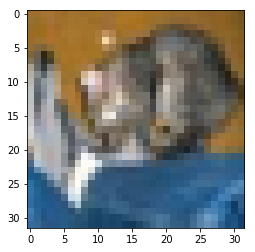

In [201]:
x_np_a = x.permute(0,2,3,1).numpy().squeeze()
plt.imshow(x_np_a)

In [202]:
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
x = img.new(*img.size())
x[:, 0, :, :] = img[:, 0, :, :] * std[0] + mean[0]
x[:, 1, :, :] = img[:, 1, :, :] * std[1] + mean[1]
x[:, 2, :, :] = img[:, 2, :, :] * std[2] + mean[2]

In [203]:
x_np = x.permute(0,2,3,1).numpy().squeeze()
plt.imshow(x_np)

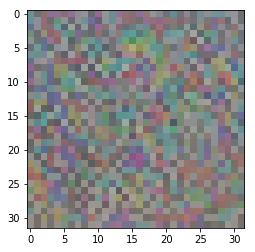

In [204]:
difference = x_np_a - x_np
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)

In [214]:
idx = trainset.train_labels == 1 

In [215]:
classes

('plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck')

In [218]:
trainset = torchvision.datasets.CIFAR10(root='./data/Cifar', train=True,
                                        download=True, transform=transform)

Files already downloaded and verified


In [219]:
trainset.train_labels = trainset.train_labels[idx]
trainset.train_data = trainset.train_data[idx]

In [224]:
from torch.utils.data import SubsetRandomSampler

In [229]:
def get_indices(dataset,class_names):
    indices =  []
    for i in range(len(dataset.train_labels)):
        for c in class_names:
            if dataset.train_labels[i] == c:
                indices.append(i)
    return indices


dataset = torchvision.datasets.CIFAR10(root='./data/Cifar',
                           transform=torchvision.transforms.ToTensor())

idx = get_indices(dataset, [3,4,6])
loader = torch.utils.data.DataLoader(dataset,batch_size=64, sampler = SubsetRandomSampler(idx))

for idx, (data, target) in enumerate(loader):
    print(target, len(target))

tensor([6, 4, 6, 6, 4, 6, 3, 3, 4, 4, 4, 4, 3, 6, 3, 6, 6, 3, 4, 4, 4, 4, 6, 6,
        3, 6, 4, 3, 3, 6, 4, 6, 4, 3, 4, 4, 6, 4, 4, 6, 6, 4, 4, 3, 6, 3, 4, 4,
        4, 6, 6, 4, 4, 6, 3, 4, 3, 4, 6, 6, 4, 4, 4, 6]) 64
tensor([4, 3, 4, 4, 6, 4, 6, 4, 3, 3, 4, 3, 6, 3, 6, 3, 6, 4, 6, 3, 4, 4, 3, 3,
        4, 3, 3, 3, 4, 3, 3, 6, 3, 4, 6, 6, 3, 4, 4, 3, 4, 6, 6, 6, 3, 6, 4, 4,
        4, 6, 3, 6, 3, 4, 6, 4, 3, 6, 6, 4, 4, 4, 4, 3]) 64
tensor([4, 6, 6, 4, 6, 4, 4, 3, 3, 6, 6, 4, 4, 4, 4, 4, 3, 6, 6, 3, 6, 3, 6, 4,
        4, 4, 3, 3, 4, 6, 3, 3, 3, 6, 4, 3, 4, 3, 6, 6, 4, 4, 6, 4, 4, 3, 3, 4,
        6, 4, 4, 4, 6, 3, 4, 4, 6, 6, 3, 6, 6, 3, 6, 3]) 64
tensor([3, 4, 3, 4, 4, 3, 4, 6, 6, 3, 4, 3, 4, 4, 6, 3, 4, 6, 3, 3, 3, 4, 3, 4,
        4, 4, 6, 3, 4, 6, 3, 6, 4, 3, 3, 6, 6, 3, 3, 3, 6, 3, 6, 4, 3, 4, 4, 3,
        6, 3, 4, 4, 3, 4, 3, 6, 3, 3, 6, 6, 6, 4, 6, 6]) 64
tensor([4, 6, 4, 6, 4, 6, 6, 4, 3, 4, 4, 4, 6, 6, 4, 3, 4, 6, 3, 3, 6, 6, 3, 4,
        6, 6, 3, 3, 3, 3, 4, 3, 3, 4, 6,

tensor([6, 6, 4, 3, 4, 3, 4, 3, 3, 3, 3, 4, 3, 4, 6, 6, 4, 4, 3, 3, 6, 4, 4, 6,
        3, 4, 3, 6, 6, 3, 3, 3, 3, 6, 4, 6, 6, 6, 3, 6, 6, 4, 3, 4, 4, 6, 3, 3,
        3, 3, 3, 3, 3, 3, 4, 6, 3, 3, 6, 3, 4, 4, 3, 3]) 64
tensor([6, 3, 4, 4, 4, 4, 6, 4, 3, 3, 3, 4, 3, 6, 6, 6, 3, 6, 3, 4, 6, 3, 3, 6,
        3, 3, 4, 6, 4, 6, 6, 4, 4, 4, 3, 3, 4, 4, 4, 6, 3, 6, 3, 6, 3, 3, 3, 4,
        4, 3, 4, 6, 3, 3, 6, 3, 4, 3, 6, 4, 4, 4, 4, 3]) 64
tensor([4, 6, 3, 6, 4, 6, 6, 4, 4, 4, 6, 6, 4, 3, 3, 4, 4, 6, 4, 3, 4, 6, 6, 3,
        4, 3, 6, 4, 6, 6, 6, 6, 6, 3, 4, 6, 6, 4, 6, 6, 3, 3, 4, 6, 6, 4, 6, 3,
        4, 4, 6, 4, 6, 6, 4, 6, 6, 6, 4, 6, 3, 4, 3, 6]) 64
tensor([3, 4, 6, 6, 6, 4, 6, 4, 3, 6, 3, 6, 6, 3, 4, 3, 4, 4, 3, 3, 3, 3, 6, 6,
        4, 3, 6, 4, 4, 4, 4, 3, 4, 4, 4, 4, 6, 6, 3, 6, 3, 3, 6, 4, 4, 3, 4, 6,
        6, 4, 4, 3, 6, 4, 4, 3, 4, 4, 3, 3, 4, 6, 3, 3]) 64
tensor([3, 3, 4, 4, 4, 4, 6, 3, 3, 3, 3, 3, 3, 4, 3, 3, 6, 4, 6, 6, 4, 4, 3, 4,
        4, 3, 3, 3, 4, 6, 6, 6, 4, 3, 6,

tensor([6, 3, 4, 3, 4, 4, 6, 3, 6, 3, 6, 3, 6, 3, 3, 3, 3, 4, 3, 3, 4, 3, 3, 3,
        3, 3, 6, 6, 4, 6, 4, 4, 3, 4, 6, 6, 6, 3, 6, 6, 6, 3, 4, 3, 6, 6, 6, 4,
        4, 6, 6, 3, 4, 3, 4, 6, 3, 4, 4, 6, 3, 4, 4, 6]) 64
tensor([4, 4, 6, 4, 6, 4, 6, 6, 6, 6, 6, 3, 4, 6, 3, 6, 4, 3, 6, 3, 4, 3, 3, 6,
        4, 3, 3, 3, 3, 3, 4, 6, 6, 3, 4, 6, 6, 4, 6, 6, 4, 6, 6, 4, 4, 4, 6, 6,
        3, 6, 3, 4, 4, 6, 6, 3, 4, 6, 6, 4, 3, 4, 3, 3]) 64
tensor([6, 6, 4, 4, 6, 4, 6, 3, 4, 4, 4, 6, 4, 3, 4, 4, 4, 3, 4, 6, 4, 4, 4, 3,
        4, 6, 6, 4, 4, 6, 4, 6, 6, 6, 4, 4, 3, 6, 6, 6, 3, 6, 4, 4, 6, 6, 4, 3,
        4, 4, 3, 3, 3, 4, 3, 3, 3, 4, 3, 6, 4, 4, 6, 4]) 64
tensor([6, 6, 3, 4, 4, 6, 4, 6, 6, 4, 3, 4, 6, 4, 4, 3, 4, 3, 6, 4, 6, 3, 3, 6,
        4, 6, 3, 6, 3, 6, 3, 3, 3, 3, 6, 4, 6, 6, 3, 3, 6, 4, 3, 6, 4, 4, 6, 3,
        4, 6, 6, 6, 4, 6, 6, 3, 6, 6, 6, 3, 3, 6, 6, 6]) 64
tensor([6, 4, 6, 6, 4, 3, 6, 3, 6, 3, 6, 6, 3, 3, 4, 3, 6, 3, 6, 6, 3, 6, 6, 3,
        6, 4, 4, 4, 6, 3, 4, 6, 3, 4, 6,

tensor([3, 3, 3, 3, 4, 4, 3, 4, 3, 6, 3, 3, 3, 6, 3, 6, 6, 6, 3, 3, 4, 4, 3, 4,
        4, 6, 4, 6, 4, 4, 3, 4, 6, 6, 3, 3, 6, 4, 6, 6, 4, 4, 3, 6, 6, 6, 3, 3,
        4, 4, 6, 4, 6, 3, 6, 4, 3, 4, 4, 4, 6, 3, 4, 4]) 64
tensor([4, 6, 4, 6, 4, 3, 6, 3, 6, 6, 6, 6, 6, 4, 4, 3, 6, 4, 6, 4, 3, 4, 4, 3,
        4, 3, 3, 4, 6, 3, 3, 4, 6, 4, 4, 3, 6, 6, 3, 3, 3, 6, 3, 3, 4, 6, 6, 3,
        3, 4, 4, 6, 3, 6, 3, 6, 3, 3, 4, 4, 3, 6, 3, 4]) 64
tensor([3, 3, 4, 6, 4, 6, 3, 4, 6, 4, 6, 4, 4, 4, 6, 3, 4, 6, 3, 6, 4, 3, 3, 6,
        3, 4, 4, 4, 4, 4, 4, 3, 6, 3, 3, 3, 6, 3, 3, 3, 6, 6, 3, 4, 3, 6, 4, 4,
        4, 4, 3, 6, 4, 6, 3, 6, 3, 3, 4, 3, 4, 4, 4, 6]) 64
tensor([4, 4, 4, 3, 6, 3, 3, 3, 4, 6, 3, 6, 6, 6, 3, 6, 3, 3, 6, 4, 3, 6, 3, 6,
        3, 4, 3, 4, 3, 6, 3, 4, 3, 6, 3, 3, 6, 4, 3, 4, 4, 3, 3, 6, 6, 4, 6, 3,
        3, 3, 4, 4, 4, 4, 3, 6, 3, 3, 4, 4, 3, 3, 4, 6]) 64
tensor([3, 4, 6, 6, 4, 3, 4, 3, 4, 4, 6, 6, 6, 6, 4, 4, 6, 3, 3, 4, 6, 6, 4, 3,
        3, 3, 6, 3, 6, 3, 6, 4, 4, 6, 4,

tensor([3, 4, 3, 3, 6, 3, 6, 6, 3, 6, 4, 6, 6, 6, 4, 4, 6, 3, 6, 6, 6, 3, 6, 3,
        4, 6, 3, 3, 6, 6, 4, 4, 3, 6, 6, 3, 4, 6, 6, 4, 4, 3, 6, 6, 4, 3, 4, 6,
        6, 3, 6, 4, 4, 3, 6, 6, 6, 4, 4, 3, 3, 4, 6, 3]) 64
tensor([4, 3, 3, 3, 6, 6, 4, 6, 3, 6, 6, 6, 3, 3, 6, 6, 3, 6, 3, 4, 6, 6, 4, 6,
        4, 6, 3, 3, 4, 3, 6, 3, 4, 3, 4, 4, 4, 6, 3, 4, 6, 6, 3, 3, 4, 6, 4, 4,
        4, 4, 3, 6, 6, 4, 3, 3, 3, 3, 6, 3, 3, 6, 4, 4]) 64
tensor([6, 6, 6, 3, 4, 4, 6, 3, 4, 6, 4, 4, 3, 3, 6, 6, 6, 4, 6, 3, 6, 6, 4, 6,
        3, 3, 4, 3, 6, 6, 3, 6, 6, 3, 3, 3, 4, 6, 4, 6, 3, 3, 4, 3, 6, 4, 6, 6,
        3, 6, 4, 4, 3, 4, 4, 4, 3, 3, 3, 4, 6, 6, 4, 3]) 64
tensor([3, 6, 6, 6, 4, 3, 6, 6, 6, 4, 3, 4, 6, 6, 6, 6, 3, 4, 6, 4, 4, 3, 3, 4,
        6, 6, 4, 3, 3, 6, 6, 4, 6, 4, 3, 3, 3, 6, 3, 4, 6, 4, 6, 6, 6, 4, 3, 3,
        3, 6, 6, 4, 6, 6, 4, 6, 3, 6, 4, 3, 4, 4, 3, 4]) 64
tensor([3, 6, 4, 4, 3, 6, 6, 4, 3, 3, 3, 3, 6, 4, 3, 3, 4, 4, 6, 4, 4, 3, 3, 3,
        6, 4, 6, 4, 3, 3, 6, 4, 4, 3, 6,

tensor([4, 6, 4, 4, 6, 6, 6, 3, 4, 3, 3, 6, 3, 4, 6, 3, 6, 4, 6, 4, 6, 4, 6, 3,
        3, 3, 4, 4, 4, 3, 3, 6, 6, 6, 3, 3, 4, 6, 3, 4, 3, 4, 3, 4, 6, 3, 6, 3,
        3, 6, 4, 6, 6, 3, 6, 4, 6, 6, 6, 3, 4, 3, 4, 4]) 64
tensor([3, 3, 3, 4, 3, 4, 4, 4, 4, 3, 3, 6, 6, 6, 4, 3, 3, 3, 3, 3, 6, 3, 4, 4,
        3, 4, 6, 3, 6, 3, 4, 4, 3, 6, 6, 3, 6, 4, 6, 6, 4, 4, 3, 4, 6, 4, 3, 3,
        6, 3, 3, 4, 6, 4, 4, 6, 3, 3, 6, 4, 3, 6, 4, 6]) 64
tensor([4, 3, 3, 4, 3, 4, 4, 3, 4, 6, 6, 3, 6, 3, 3, 6, 4, 4, 3, 3, 6, 4, 4, 3,
        6, 4, 4, 3, 6, 3, 4, 6, 6, 4, 4, 6, 3, 4, 4, 3, 6, 3, 6, 6, 6, 4, 6, 6,
        4, 4, 4, 6, 4, 6, 3, 4, 3, 4, 3, 4, 3, 6, 4, 4]) 64
tensor([6, 6, 3, 6, 6, 3, 4, 4, 4, 6, 3, 6, 3, 4, 4, 6, 3, 4, 4, 6, 6, 3, 3, 6,
        6, 3, 6, 3, 6, 3, 4, 3, 4, 4, 4, 3, 4, 4, 6, 3, 3, 3, 3, 3, 4, 4, 4, 4,
        4, 4, 3, 3, 4, 4, 3, 3, 4, 3, 3, 4, 3, 3, 3, 4]) 64
tensor([6, 4, 4, 3, 3, 3, 3, 6, 6, 6, 4, 3, 6, 3, 4, 6, 4, 3, 3, 6, 6, 3, 4, 6,
        3, 4, 4, 6, 3, 4, 4, 6, 3, 3, 3,

In [264]:
from scipy.stats import multivariate_normal

In [265]:
def find_prob(mu):
    # Here we find the probability of a particular latent variable
    # coming from a standard Normal N(0,I). We just use the mu value
    # we get. This is because the latent distribution is supposed
    # to be N(mu, var), and expectation of this is simply mu.

    probs = multivariate_normal.pdf(mu.data.cpu().numpy().transpose())
    #mean_probs_dims = np.mean(probs)

    #prob = multivariate_normal.pdf(mu.data.numpy().transpose(), mean=np.zeros(128), cov=np.eye(128))

    mean_probs_dims = np.sum(np.log(probs))
    return probs, mean_probs_dims

## LOAD VAE

In [556]:
from model import BetaVAE_H

In [658]:
path_vae_ckp = 'checkpoints/'
env_name = 'ayan_run_cifar10_z128_beta0.5'
ckp_name = 'last'
ckp = os.path.join(path_vae_ckp, env_name, ckp_name)

In [660]:
ckp_obj = torch.load(ckp)
vae_net = BetaVAE_H(z_dim=128, nc=3, use_cuda=False, small=True)
vae_net.load_state_dict(ckp_obj['model_states']['net'])

HERE WE ARE


In [661]:
vae_net.eval()

BetaVAE_H(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace)
    (4): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace)
    (6): Conv2d(64, 256, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace)
    (8): View()
    (9): Linear(in_features=256, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): View()
    (2): ReLU(inplace)
    (3): ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(1, 1))
    (4): ReLU(inplace)
    (5): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace)
    (7): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (8): ReLU(inplace)
    (9): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding

In [779]:
#fmodel = foolbox.models.PyTorchModel(model, bounds=(-3, 3), num_classes=10, preprocessing=(mean, std))
fmodel = foolbox.models.PyTorchModel(model, bounds=(0, 1), num_classes=10)

In [780]:
val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data/Cifar', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
        ])),
        batch_size=1, shuffle=False,
        num_workers=1, pin_memory=True)

In [781]:
# def get_indices(dataset,class_names):
#     indices =  []
#     #for i in range(len(dataset.train_labels)):
#     for i in range(len(dataset.test_labels)):
#         for c in class_names:
#             if dataset.test_labels[i] == c:
#                 indices.append(i)
#     return indices


# dataset = torchvision.datasets.CIFAR10(root='./data/Cifar',
#                            transform=torchvision.transforms.ToTensor(), train=False)

# idx = get_indices(dataset, [0,1,7])
# loader = torch.utils.data.DataLoader(dataset,batch_size=1, sampler = SubsetRandomSampler(idx))

# #for idx, (data, target) in enumerate(loader):
# #    print(target, len(target))

In [801]:
it_val = iter(val_loader)
for i in range(6):
    img, lbl = it_val.next()

In [802]:
# mean=[0.485, 0.456, 0.406]
# std=[0.229, 0.224, 0.225]
# x = img.new(*img.size())
# x[:, 0, :, :] = img[:, 0, :, :] * std[0] + mean[0]
# x[:, 1, :, :] = img[:, 1, :, :] * std[1] + mean[1]
# x[:, 2, :, :] = img[:, 2, :, :] * std[2] + mean[2]

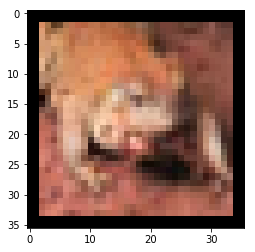

In [803]:
#x_np = img.permute(0,2,3,1).numpy().squeeze()
#plt.imshow(x_np)
x_np = make_grid(img.data, normalize=True, nrow=1)
plt.imshow(x_np.permute(1,2,0).numpy())

In [804]:
x_recon, mu, logvar, _ = vae_net(img)

In [805]:
from torchvision.utils import make_grid

In [806]:
rec_np = make_grid(x_recon.data, normalize=True, nrow=1)

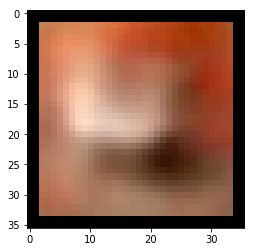

In [807]:
plt.imshow(rec_np.permute(1,2,0).numpy())

In [808]:
i = img.numpy().squeeze()
l = lbl.numpy().squeeze()
print('predicted class', classes[np.argmax(fmodel.predictions(i))])
fbgrad = fmodel.gradient(i,l)
#crit = Misclassification()
#crit = foolbox.criteria.TargetClass(9)
#dist = Linfinity()
#attack = foolbox.attacks.LBFGSAttack(fmodel, criterion=crit)
attack = foolbox.attacks.BasicIterativeMethod(fmodel)
adversarial = attack(input_or_adv=i, label=l)
print('adversarial class', classes[np.argmax(fmodel.predictions(adversarial))])
adv = torch.Tensor(adversarial).unsqueeze(0)

predicted class frog
adversarial class cat


In [810]:
adv_recon, adv_mu, adv_logvar, _ = vae_net(adv)

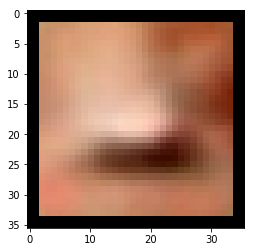

In [811]:
adv_rec_np = make_grid(adv_recon.data, normalize=True, nrow=1)
plt.imshow(adv_rec_np.permute(1,2,0).numpy())

In [812]:
adv_recon.shape

torch.Size([1, 3, 32, 32])

In [813]:
classes[np.argmax(fmodel.predictions(x_recon.squeeze().detach().numpy()))]

'cat'

In [814]:
probs, mean_prob_dims = find_prob(mu)

In [815]:
logvar.data.exp().mean()

tensor(0.7741)

In [816]:
adv_logvar.data.exp().mean()

tensor(0.7741)

In [817]:
mean_prob_dims

-127.20812234405815

In [818]:
adv_probs, adv_mean_prob_dims = find_prob(adv_mu)

In [819]:
adv_mean_prob_dims

-127.20856320137946

In [427]:
val_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data/Cifar', train=True, transform=transforms.Compose([
            transforms.ToTensor(),
        ])),
        batch_size=32, shuffle=False,
        num_workers=1, pin_memory=True)

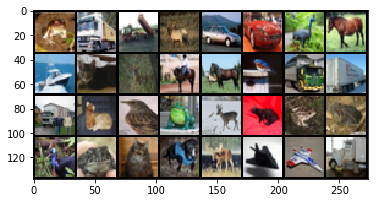

 frog truck truck  deer   car   car  bird horse  ship   cat  deer horse horse  bird truck truck truck   cat  bird  frog  deer   cat  frog  frog  bird  frog   cat   dog  deer plane plane truck


In [428]:
# functions to show an image


def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(val_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(32)))


## TEST

In [555]:
it_val = iter(loader)
for i in range(5000):
    img, lbl = it_val.next()
    x_recon, mu, logvar, _ = vae_net(img)
    i = img.numpy().squeeze()
    l = lbl.numpy().squeeze()
    #print('predicted class', classes[np.argmax(fmodel.predictions(i))])
    fbgrad = fmodel.gradient(i,l)
    #crit = Misclassification()
    #crit = foolbox.criteria.TargetClass(9)
    #dist = Linfinity()
    #attack = foolbox.attacks.LBFGSAttack(fmodel, criterion=crit)
    attack = foolbox.attacks.FGSM(fmodel)
    adversarial = attack(input_or_adv=i, label=l)
    #print('adversarial class', classes[np.argmax(fmodel.predictions(adversarial))])
    adv = torch.Tensor(adversarial).unsqueeze(0)
    adv_recon, adv_mu, adv_logvar, _ = vae_net(adv)
    ad_r_pred = classes[np.argmax(fmodel.predictions(adv_recon.squeeze().detach().numpy()))]
    or_r_pred = classes[np.argmax(fmodel.predictions(x_recon.squeeze().detach().numpy()))]
    print("Rec_Img:", (fmodel.predictions(adv_recon.squeeze().detach().numpy())))
    print("Rec_Adv:", (fmodel.predictions(x_recon.squeeze().detach().numpy())))
    if ad_r_pred != or_r_pred:
        print("Rec_Img:", ad_r_pred)
        print("Rec_Adv:", or_r_pred)
    print("------------------------------------------")

Rec_Img: [ 1.9749159   0.04484659  0.18198103  0.11495055 -3.1882453  -1.4866235
 -0.22541617 -7.0789843   9.577734    0.08234286]
Rec_Adv: [ 1.9678352  -0.22179846  0.48389032  0.1649642  -3.1773944  -1.4566088
 -0.19688968 -7.0145636   9.466556   -0.01846328]
------------------------------------------
Rec_Img: [10.350524   -0.8799043   0.9835114   0.03627798  0.62466425 -3.8588367
 -7.2063375  -0.10299838  0.22304758 -0.17246798]
Rec_Adv: [ 9.980447   -1.0441344   1.2975186   0.13077928  1.0502965  -3.8260207
 -6.8075814  -0.16588654  0.19962698 -0.8174182 ]
------------------------------------------
Rec_Img: [ 0.35992396 -0.34913626 -2.4245749   1.6826087  -7.7855554   1.3165836
 -3.3739512   1.6619529  -0.5791404   9.486212  ]
Rec_Adv: [-2.8978527  -5.505981    1.5037342   1.5008522  -0.24354279  9.184237
 -1.5923496   0.329958   -1.4109584  -0.8696111 ]
Rec_Img: truck
Rec_Adv: dog
------------------------------------------
Rec_Img: [ 1.8640957  -3.3375316   0.8588879   2.8618848  

Rec_Img: [ 8.840462   -1.6640984   0.5146789   1.7299851   0.3632506  -2.7834558
 -6.795296   -0.19145325 -0.07426429  0.05740936]
Rec_Adv: [10.059734   -1.1550574   0.94657874  0.3443023   0.39326608 -3.509515
 -7.214424   -0.03669116  0.10912284  0.06010589]
------------------------------------------
Rec_Img: [ 8.847129   -1.4833406   0.6683655   0.34400037 -1.0593915  -2.321882
 -7.130702    0.79083884 -0.5638658   1.9059116 ]
Rec_Adv: [ 8.365221   -1.4199677   0.31773973  0.71822596 -1.2147832  -2.2201688
 -6.985517    1.1433523  -0.97434074  2.2671835 ]
------------------------------------------


KeyboardInterrupt: 